In [1]:
import sncosmo
import numpy as np
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
import pickle as pk
from matplotlib.backends.backend_pdf import PdfPages
import os 
from matplotlib.offsetbox import AnchoredText
import astropy.constants as const
import astropy.units as u
import seaborn as sns

sns.set(style='whitegrid')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
SCALE_FACTOR = 1e-12

## Comentários

Estou testando cortar partes dos filtros pros modelos falharem menos.

Algumas SNe estão repetidas. Não há ajuste duplicado porque há uma ordem para checar se existem os arquivos, então o último a ser checado é o ajustado. Mas isso é um problema a ser observado.

A covariância afeta bastante o resultado do CHISQ inclusive para o SALT2 e SALT2 cortado, então acho que podemos ser flexíveis nesse corte ou melhorar o modelo da covariância do EXP.

## Recuperando curvas de luz

In [2]:
path="/home/cassia/SNANA/snroot/lcmerge/JLA2014_SNLS/"

In [3]:
sne_snls_pan=pd.read_csv("snls_pantheon.txt",header=None,dtype=str)

In [4]:
sne_list=np.array(sne_snls_pan).T[0]

In [5]:
path_filters="/home/cassia/SNANA/snroot/filters/PS1/Pantheon/SNLS3-Megacam/"

## Registrando filtros

In [6]:
ab = sncosmo.get_magsystem('ab')

In [7]:
for sn in sne_list:
    for filt in ["g","r","i","z"]:
        wave = pd.read_csv(path_filters+"effMEGACAM-"+filt+".dat",header=None,sep="\s+",comment="#")[0].values
        trans = pd.read_csv(path_filters+"effMEGACAM-"+filt+".dat",header=None,sep="\s+",comment="#")[1].values
        band = sncosmo.Bandpass(wave, trans, name="SNLS_"+filt,trim_level=0.05)
        
        sncosmo.registry.register(band, force=True)

In [8]:
magsystem={"SNLS_g":("ab",-0.0067+ 0.0076605430),
        "SNLS_r":("ab",-0.0081-0.0012669564),
        "SNLS_i":("ab",-0.0073-0.0057157707),
        "SNLS_z":("ab",-0.0078+0.0024809218)}

## Ajustando curvas de luz

In [9]:
def lc_fit(sn):    
    try:
        meta, tables = sncosmo.read_snana_ascii(path+"JLA2014_SNLS_"+sn+".dat", default_tablename='OBS')
    except:
        print(f"File not found for SN {sn}")
        return None
    
    dat=tables["OBS"]
    surv="SNLS"

    dat.add_column([surv+"_"+f for f in dat["FLT"]], name='FILTER')
    dat.remove_column("FLT")
     
    dat.remove_rows(np.where(dat["FLUXCAL"]<0)[0])
    dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])
     
    magsys=sncosmo.CompositeMagSystem(bands=magsystem,name="magsys")
    sncosmo.register(magsys,force=True)
        
    dat["ZP"]=[2.5*np.log10(magsys.zpbandflux(f)) for f in dat["FILTER"]]    
    dat["FLUX"]=[10**(-0.4*dat["MAG"][i]+0.4*dat["ZP"][i]) for i in range(len(dat["MAG"]))]
    dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]
    dat.add_column("ab", name='ZPSYS')

    dat.remove_columns(["FIELD","SNR","MAG","MAGERR","Zpt"])
    
    # ref de repouso: (t-t0)/(1+z), no SNANA fazem um corte de -15 a 45 no referencial de repouso. E também tem um corte no 
    # intervalo de comprimento de onda, eu apliquei esses cortes abaixo em phase_range e wave_range. Porém não tenho certeza
    # se o sncosmo corta no ref de repouso ou do observador. Alterando isso, os valores de x1 para 2001ah e 2001az mudam drasticamento
    # equivalendo a mesma mudança que ocorre no snana quando fazemos a mesma alteração no TREST_REJECT.    
        
    dust = sncosmo.F99Dust() 

    # para algumas sne como 2006bb o chi2 da minimizacao da Nan e não é possível ajustar a sn. A mesma sn no snana é ajustada pelo salt.
    # alterando intervalo de dias e comprimento de onda de atuação do ajustador, ainda não é possível evitar o nan já no primeiro passo.
    
    rm_f=[]
    if sn in ["03D1fq","03D4cx","03D4cz","03D4di","04D1iv","04D1pp","04D2iu","04D3dd","04D3lu","04D3ml","04D4dw","04D4ic","04D4ih",
              "04D4jw","05D1az","05D1cl","05D3kp","05D4cs","05D4ev","06D2ce","06D4ce","03D4cy","04D1de","04D1hy","04D2gp","04D3fq",
              "04D3lp","04D3nc","04D3nr","04D3oe","04D4bk","04D4dm","04D4hf","04D4ib","05D1eo","05D1iz","05D2by","05D2my","05D2nt",
              "05D3cx","05D3gv","05D3ht","05D3jh","05D4bi","05D2ob","05D2nn","05D4dw","04D4im","05D2bw","05D4hn","06D4cl","06D3bz","06D3en"]:
        dat.remove_rows(np.where(dat["FILTER"]=="SNLS_g"))
        rm_f.append("SNLS_g")
    if sn in ["03D1au","04D1iv","04D4an","04D4hu","04D4ic","04D4ih","04D4im","04D4jw","05D2hc","05D3gp","05D4bf","05D4ev","06D2cc",
              "06D2ce","06D3em","03D1aw","04D1jd","04D1pu","04D4id","04D4ii","05D1kl","05D3ci","05D3mh","05D3mq","05D4bi","06D2cd",
              "06D2ck","06D2ga"]:
        dat.remove_rows(np.where(dat["FILTER"]=="SNLS_z"))
        rm_f.append("SNLS_z")
    
    model = sncosmo.Model(source='salt2',effects=[dust],effect_names=['mw'],effect_frames=['obs'])
    model.set(mwebv=meta["MWEBV"],z=meta["REDSHIFT_FINAL"]) 
    try:
        result, fitted_model = sncosmo.fit_lc(dat, model, ['t0', 'x0', 'x1', 'c'],modelcov=True, phase_range=(-15,45), wave_range=(3000,7000), verbose=False)
    except:
        print(f"SN {sn} fit returns NaN")
        result=None
        fitted_model=None
    
    return meta, surv, rm_f, dat, result, fitted_model

In [10]:
pp = PdfPages("./lc_fit_plot_SALT2_SNLS_Pantheon.pdf")

In [11]:
def lc_fit_plot(sn, surv, rm_f ,table_data, result, fitted_model):
    z=round(result["parameters"][0],2)
    t0=round(result["parameters"][1],2)
    x1=round(result["parameters"][3],2)
    x1err=round(result["errors"]["x1"],2)
    c=round(result["parameters"][4],2)
    cerr=round(result["errors"]["c"],2)
    mwebv=result["parameters"][5]
    phase=np.linspace(t0-15.,t0+45.,100)
    fig=plt.figure(figsize=(12,8))
    for i,f in enumerate(["SNLS_"+filt for filt in ["g","r","i","z"]]):
        dados_cortados=table_data[(table_data["MJD"]>=t0-15.) & (table_data["MJD"]<=t0+45.) & (table_data["FILTER"]==f)]
        if len(dados_cortados)==0:
            continue
        elif f not in rm_f:
            plt.errorbar(dados_cortados["MJD"]-t0,dados_cortados["FLUXCAL"],yerr=dados_cortados["FLUXCALERR"],label=f,ls="none", marker='o',markersize=8,color='C%i'%i)
            plt.plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*dados_cortados["ZP"][0]+11),linewidth=3,color='C%i'%i)
            plt.xlabel(f"MJD-{t0}",fontsize=15)
            plt.ylabel(r"FLUX ($Z_{AB}$=27.5)",fontsize=15)
            plt.title(f"SALT2 fit, SN: {sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   c={c:.2f}$\pm${cerr:.2f},   $\chi^2$={result.chisq/result.ndof:.2f}",fontsize=15)
            plt.xlim(-17,47)
            plt.legend(fontsize=15)
        else:
            continue
    pp.savefig()
    plt.close(fig)
    #plt.show()

In [12]:
 def return_fit_data(meta,res,model_name):
    free_par=(list(res.errors.keys()))

    return [meta["SNID"], "SNLS", meta["REDSHIFT_FINAL"], 0., res.parameters[1],
           res.errors[free_par[0]], res.parameters[2], res.errors[free_par[1]], res.parameters[3],
           res.errors[free_par[2]], res.parameters[4], res.errors[free_par[3]],
           res.covariance[1][2], res.covariance[1][3], res.covariance[2][3], 
           res.chisq/res.ndof, model_name]

In [13]:
all_fit_data=[]
f=open("./lc_failed_fits_SALT2_SNLS_Pantheon.txt","w")
i=0
for sn in sne_list:

    meta, surv, rm_f, table_data, result, fitted_model=lc_fit(sn) 

    if result is None:
        f.write(f"SN {sn} fit returns NaN\n")
        continue
    else:
        if result.success and result.ndof>0:
            all_fit_data.append(return_fit_data(meta,result,"SALT2_ORI"))
        elif result.success and result.ndof==0:
            f.write("ndof 0 for SN"+sn+"\n")
        elif not result.success:
            f.write("Unsuccessful fit of SN"+sn+"\n")

    lc_fit_plot(sn, surv, rm_f, table_data, result, fitted_model)                       

In [14]:
pp.close()

In [15]:
f.close()

## Salvando dados dos ajustes

In [16]:
df=pd.DataFrame(all_fit_data)

In [17]:
df=pd.DataFrame(all_fit_data)
df.columns=("SNNAME", "SURVEY", "Z", "ZERR", "T0", "T0ERR", "X0", "X0ERR", "X1", "X1ERR", "X2/C", "X2/CERR", "COV_X0_X1", "COV_X0_X2/C", "COV_X1_X2/C", "CHISQ/NDOF", "MODEL")

In [18]:
df["mB"]=-2.5*np.log10(df["X0"])+10.635  # Mosher 2014
df["mBERR"]=np.abs(-2.5*np.log10(np.e)/df["X0"]*df["X0ERR"])
df["COV_mB_X1"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X1"]
df["COV_mB_X2/C"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X2/C"]

In [19]:
df.to_csv("./lc_fit_results_SALT2_SNLS_Pantheon.txt", sep=' ', index=False)

## Análises dos Ajustes

In [20]:
df_salt2_bf_cuts=df[df["MODEL"]=="SALT2_ORI"].reset_index(drop=True)
df_salt2=df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X1"])<=3.) & (abs(df["X2/C"])<=0.3) & (df["CHISQ/NDOF"]<=5.)].reset_index(drop=True)

In [21]:
df[df["CHISQ/NDOF"]>5.]

,SNNAME,SURVEY,Z,ZERR,T0,T0ERR,X0,X0ERR,X1,X1ERR,...,X2/CERR,COV_X0_X1,COV_X0_X2/C,COV_X1_X2/C,CHISQ/NDOF,MODEL,mB,mBERR,COV_mB_X1,COV_mB_X2/C


In [22]:
passcut_salt2=len(df[df["MODEL"]=="SALT2_ORI"])
passcut_salt2_x1=len(df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X1"])<=3.)])
passcut_salt2_c=len(df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X2/C"])<=0.3)])
passcut_salt2_chi2=len(df[(df["MODEL"]=="SALT2_ORI") & (df["CHISQ/NDOF"]<=5.)])

#### Checando distribuição dos parâmetros

De um total 172 SNe, 236 foram bem ajustadas.
0 não passaram no corte de |X1| < 3.
0 não passaram no corte de |C| < 0.3
0 não passaram no corte de Chi2 < 5.
No final ficamos com 236 Sne.


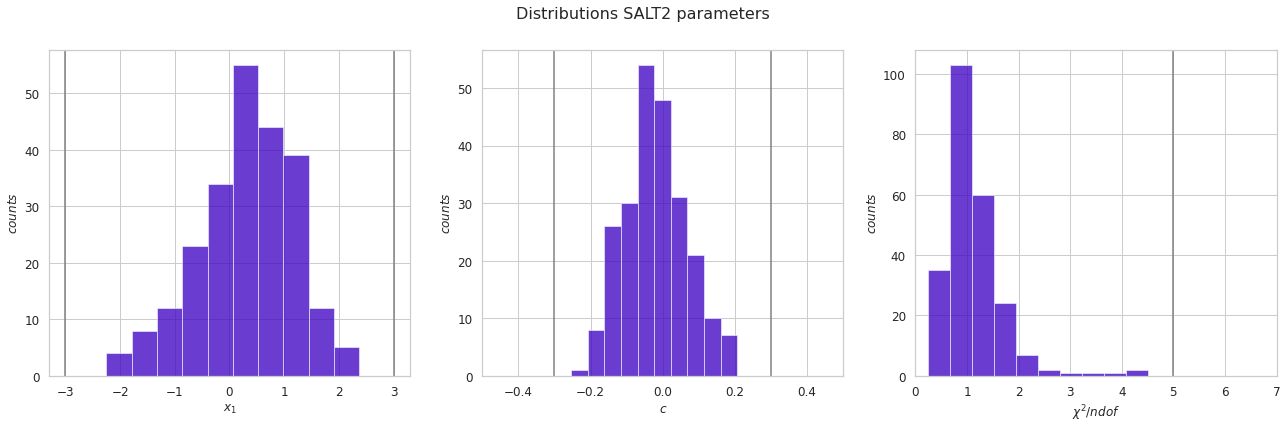

In [25]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Distributions SALT2 parameters",fontsize=16)

bins = 10
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X1"], df_salt2["X1"])), bins=bins)[1]
ax1.hist(df_salt2_bf_cuts["X1"],color="purple",bins=bins,alpha=0.6)
ax1.hist(df_salt2["X1"],color="blue",bins=bins,alpha=0.4)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$counts$")
ax1.axvline(3.,c="gray")
ax1.axvline(-3.,c="gray")

bins = 10
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X2/C"], df_salt2["X2/C"])), bins=bins)[1]
ax2.hist(df_salt2_bf_cuts["X2/C"],bins=bins,color="purple",alpha=0.6)
ax2.hist(df_salt2["X2/C"],color="blue",alpha=0.4,bins=bins)
ax2.set_xlabel(r"$c$")
ax2.set_ylabel(r"$counts$")
ax2.set_xlim(-0.5,0.5)
ax2.axvline(0.3,c="gray")
ax2.axvline(-0.3,c="gray")

bins = 10
bins = np.histogram(np.hstack((df_salt2_bf_cuts["CHISQ/NDOF"], df_salt2["CHISQ/NDOF"])), bins=bins)[1]
ax3.hist(df_salt2_bf_cuts["CHISQ/NDOF"],bins=bins,color="purple",alpha=0.6)
ax3.hist(df_salt2["CHISQ/NDOF"],bins=bins,color="blue",alpha=0.4)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel(r"$counts$")
ax3.set_xlim(0,7)
ax3.axvline(0.,c="gray")
ax3.axvline(5.,c="gray")

print(f"De um total 172 SNe, {passcut_salt2} foram bem ajustadas.")
print(f"{passcut_salt2-passcut_salt2_x1} não passaram no corte de |X1| < 3.")
print(f"{passcut_salt2-passcut_salt2_c} não passaram no corte de |C| < 0.3")
print(f"{passcut_salt2-passcut_salt2_chi2} não passaram no corte de Chi2 < 5.")
print(f"No final ficamos com {len(df_salt2)} Sne.")

#### Checando correlação entre os parâmetros

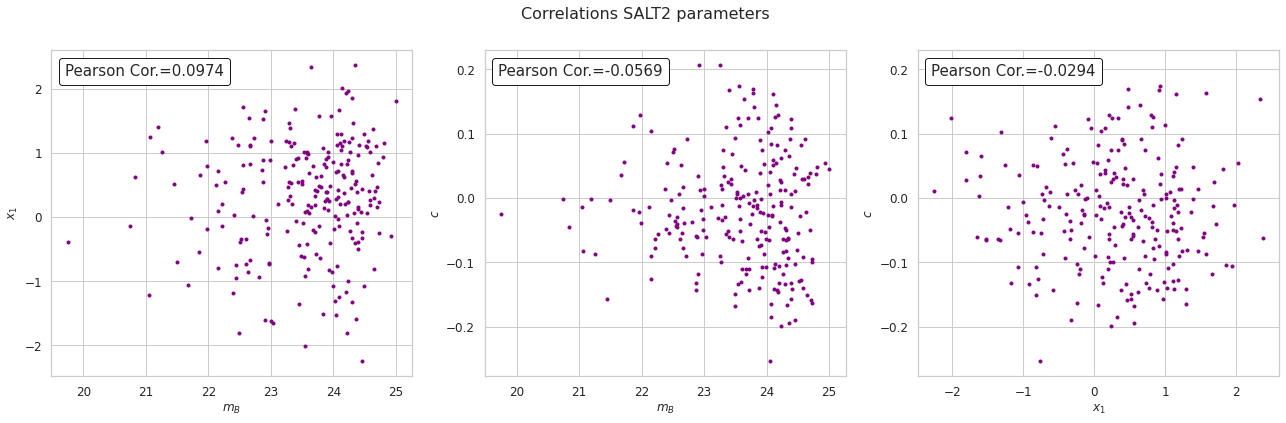

In [24]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Correlations SALT2 parameters",fontsize=16)

ax1.plot(df_salt2["mB"],df_salt2["X1"],'.',c="purple")
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_salt2["mB"],df_salt2["X2/C"],'.',c="purple")
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"$c$")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_salt2["X1"],df_salt2["X2/C"],'.',c="purple")
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"$c$")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["X1"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3);